## Step 1: Imports and Setup

In [1]:
import sys
from pathlib import Path
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR

# add deep_learning_tools path
package_root = Path.cwd().parent / 'deep_learning_tools'
sys.path.append(str(package_root))

from src import prepare_datasets, ModelTrainer, accuracy, precision, recall, f1_score

# parameters
dataset_name = 'CIFAR10'
data_root = Path.cwd().parent / 'data'
download_data = True
normalize_data = True

## Step 2: Data Preparation


In [2]:
# prepare datasets
trainset, valset = prepare_datasets(dataset_name, data_root, 
                                    normalize=normalize_data, 
                                    precalculated_stats=(0.4733640253543854, 0.21108488738536835))

Files already downloaded and verified
Files already downloaded and verified


## Step 3: Define CNN Architectures

### Model 1: Simple CNN


In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # input: 3x32x32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # output: 32x32x32
        self.relu1 = nn.ReLU()
        # output size: 32x32x32
        self.pool1 = nn.MaxPool2d(2, 2)
        # output size: 32x16x16

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # output: 64x16x16
        self.relu2 = nn.ReLU()
        # output size: 64x16x16
        self.pool2 = nn.MaxPool2d(2, 2)
        # output size: 64x8x8

        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # conv1
        x = self.conv1(x)  # input: [batch, 3, 32,32], output: [batch,32,32,32]
        x = self.relu1(x)  # [batch,32,32,32]
        x = self.pool1(x)  # [batch,32,16,16]
        
        # conv2
        x = self.conv2(x)  # [batch,64,16,16]
        x = self.relu2(x)  # [batch,64,16,16]
        x = self.pool2(x)  # [batch,64,8,8]
        
        x = x.view(x.size(0), -1)  # [batch, 64*8*8]
        x = self.fc1(x)  # [batch,128]
        x = self.relu3(x)  # [batch,128]
        x = self.fc2(x)  # [batch,10]
        
        return x

In [4]:
class SuperSimpleNN(nn.Module):

    def __init__(self, input_size: int, num_classes: int):
        super().__init__()
        self.fc1 = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        
        return x

## Step 4: Initialize and Train Models

### Training Function

In [5]:
def train_model(model, model_name, num_epochs=25):
    optimizer = Adam(model.parameters(), lr=3e-4)  # weight_decay=1e-4
    # scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=None,
        batch_size=128,
        verbose=True,
        save_metrics=False,
        early_stopping_patience=5,
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
        run_karpathy_checks=True,
        seed=42,
        # strict_reproducibility=True
        # wandb_project="cifar10",
        # wandb_entity="futuregoose",
        # sweep=True,
    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs
    )
    
    return trainer

### Train Model 1: Simple CNN

In [6]:
trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [9]:
model0 = SimpleCNN()
# trainer0 = train_model(model0, "SimpleCNN", num_epochs=5)

### Train Model 2: ResNet-20 Inspired

[epoch 01] train loss: 1.6478 | val loss: 1.4581 | accuracy: 45.54%
Validation loss decreased (inf --> 1.4581). Saving model.
[epoch 02] train loss: 1.0651 | val loss: 1.5618 | accuracy: 51.85%
EarlyStopping counter: 1 out of inf
[epoch 03] train loss: 0.8062 | val loss: 0.8814 | accuracy: 70.30%
Validation loss decreased (1.4581 --> 0.8814). Saving model.
[epoch 04] train loss: 0.6651 | val loss: 0.8475 | accuracy: 71.31%
Validation loss decreased (0.8814 --> 0.8475). Saving model.
[epoch 05] train loss: 0.5663 | val loss: 0.7210 | accuracy: 75.45%
Validation loss decreased (0.8475 --> 0.7210). Saving model.
[epoch 06] train loss: 0.4973 | val loss: 0.6760 | accuracy: 78.07%
Validation loss decreased (0.7210 --> 0.6760). Saving model.
[epoch 07] train loss: 0.4432 | val loss: 0.6824 | accuracy: 77.44%
EarlyStopping counter: 1 out of inf
[epoch 08] train loss: 0.3968 | val loss: 0.6503 | accuracy: 78.62%
Validation loss decreased (0.6760 --> 0.6503). Saving model.
[epoch 09] train loss

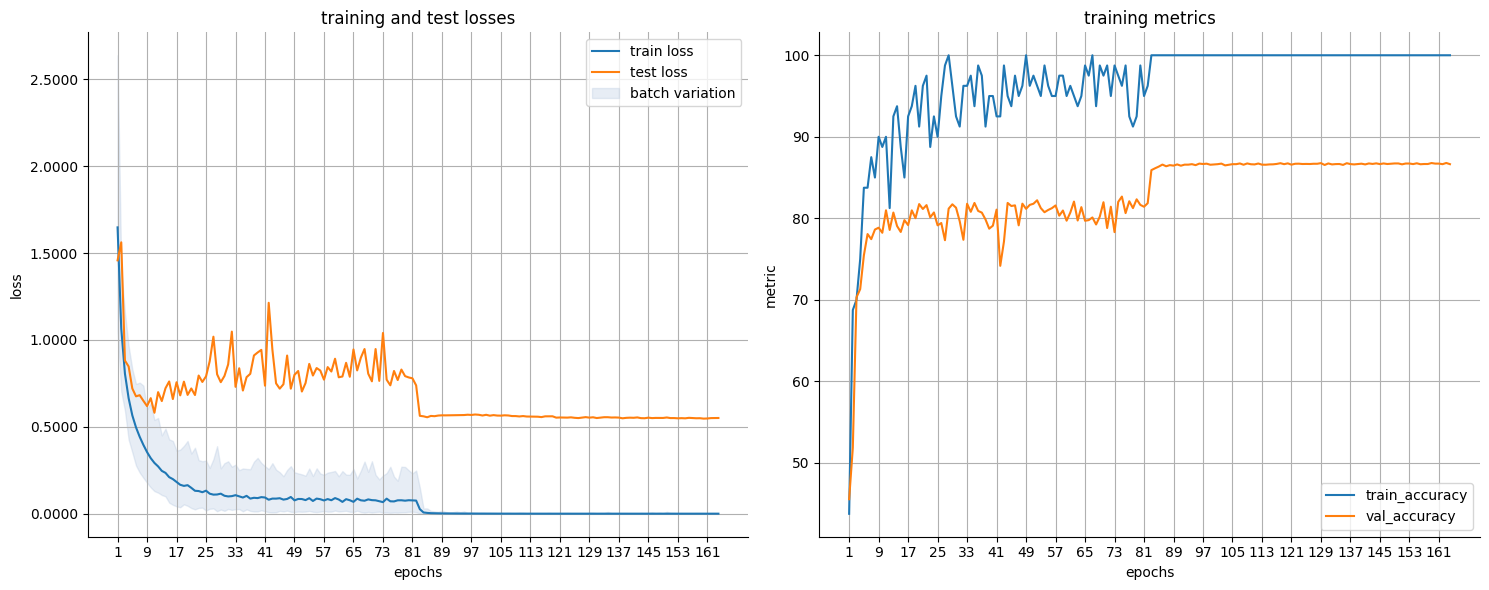

In [5]:
from torch.optim.lr_scheduler import MultiStepLR
from models.resnet20.architecture import ResNet20

def train_model(model, model_name, num_epochs=200):
    optimizer = SGD(
        model.parameters(),
        lr=0.1,
        momentum=0.9,
        weight_decay=1e-4,
        nesterov=False  # Paper doesn't mention Nesterov
    )
    
    # 32k and 48k iterations with batch_size=128
    scheduler = MultiStepLR(
        optimizer,
        milestones=[82, 123],  # ~32k and ~48k iterations
        gamma=0.1
    )
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=128,
        verbose=True,
        save_metrics=True,
        # Remove early stopping to match paper
        early_stopping_patience=float('inf'),  # effectively no early stopping
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
        run_karpathy_checks=False,
    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs  # 164 to reach ~64k iterations
    )
    
    return trainer

# Train ResNet-20
model2 = ResNet20()
trainer2 = train_model(model2, "ResNet20", num_epochs=164)

### Train Model 3: Eight Layer Conv Net

In [1]:
import sys
from pathlib import Path
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR

# add deep_learning_tools path
package_root = Path.cwd().parent / 'deep_learning_tools'
sys.path.append(str(package_root))

from src import prepare_datasets, ModelTrainer, accuracy, precision, recall, f1_score

# parameters
dataset_name = 'CIFAR10'
data_root = Path.cwd().parent / 'data'
download_data = True
normalize_data = True

Files already downloaded and verified
Files already downloaded and verified
Using FP16 (half precision) training
[epoch 01] train loss: 1.6328 | val loss: 1.4425 | accuracy: 48.31%
Validation loss decreased (inf --> 1.4425). Saving model.
[epoch 02] train loss: 1.1679 | val loss: 1.0953 | accuracy: 61.38%
Validation loss decreased (1.4425 --> 1.0953). Saving model.
[epoch 03] train loss: 0.9621 | val loss: 0.9215 | accuracy: 67.75%
Validation loss decreased (1.0953 --> 0.9215). Saving model.
[epoch 04] train loss: 0.8414 | val loss: 0.8172 | accuracy: 71.55%
Validation loss decreased (0.9215 --> 0.8172). Saving model.
[epoch 05] train loss: 0.7342 | val loss: 0.7586 | accuracy: 73.45%
Validation loss decreased (0.8172 --> 0.7586). Saving model.
[epoch 06] train loss: 0.6547 | val loss: 0.8227 | accuracy: 71.93%
EarlyStopping counter: 1 out of 2
[epoch 07] train loss: 0.6003 | val loss: 0.6659 | accuracy: 77.23%
Validation loss decreased (0.7586 --> 0.6659). Saving model.
[epoch 08] tra

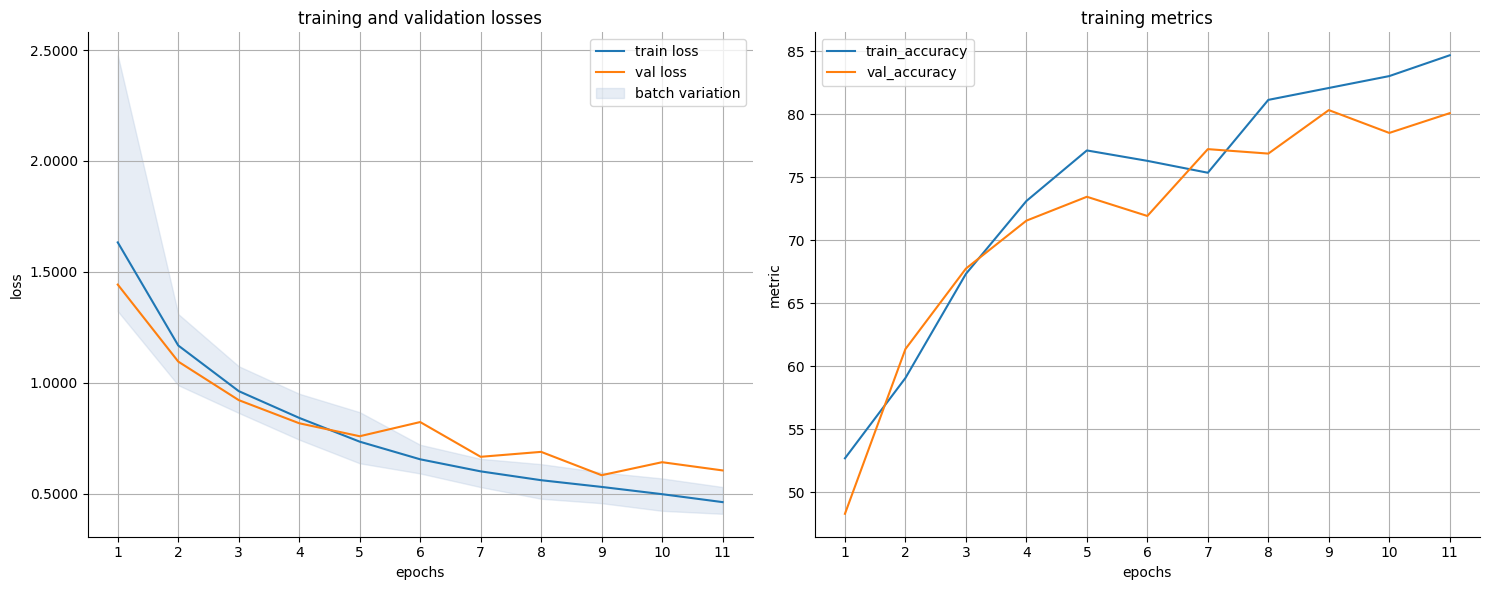

In [2]:
from models.eight_layer_conv_net.architecture import EightLayerConvNet
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torchvision import transforms


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# prepare datasets with custom transforms
trainset, valset = prepare_datasets(
    dataset_name=dataset_name, 
    data_root=data_root,
    transform_train=transform_train,
    transform_test=transform_val,
    normalize=False
)

def train_model(model, model_name, num_epochs=200):
    optimizer = SGD(
        model.parameters(),
        lr=0.1,  #  0.06697728766802258
        momentum=0.9,
        weight_decay=0.001,  # 1e-4 7.677453602367855e-05
    )
    
    # scheduler = MultiStepLR(
    #     optimizer,
    #     milestones=[6, 32],  # 6 or 15 for first
    #     gamma=0.1
    # )
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=None,  ################
        batch_size=1024,
        verbose=True,
        save_metrics=False,
        early_stopping_patience=2,
        early_stopping_delta=1e-4,  # 1e-4
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
        wandb_project="cifar10",
        wandb_entity="futuregoose",
        sweep=False,
    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs
    )
    
    return trainer

model3 = EightLayerConvNet()
trainer3 = train_model(model3, "EightLayerConvNet", num_epochs=20)

Learning rate updated to 0.01


[epoch 12] train loss: 0.4337 | val loss: 0.4761 | accuracy: 83.97%
Validation loss decreased (0.5830 --> 0.4761). Saving model.
[epoch 13] train loss: 0.4017 | val loss: 0.4733 | accuracy: 84.04%
Validation loss decreased (0.4761 --> 0.4733). Saving model.
[epoch 14] train loss: 0.3938 | val loss: 0.4635 | accuracy: 84.47%
Validation loss decreased (0.4733 --> 0.4635). Saving model.
[epoch 15] train loss: 0.3843 | val loss: 0.4673 | accuracy: 84.18%
EarlyStopping counter: 1 out of 2
[epoch 16] train loss: 0.3794 | val loss: 0.4632 | accuracy: 84.63%
Validation loss decreased (0.4635 --> 0.4632). Saving model.
[epoch 17] train loss: 0.3704 | val loss: 0.4578 | accuracy: 84.83%
Validation loss decreased (0.4632 --> 0.4578). Saving model.
[epoch 18] train loss: 0.3652 | val loss: 0.4478 | accuracy: 84.95%
Validation loss decreased (0.4578 --> 0.4478). Saving model.
[epoch 19] train loss: 0.3587 | val loss: 0.4510 | accuracy: 85.27%
EarlyStopping counter: 1 out of 2
[epoch 20] train loss:

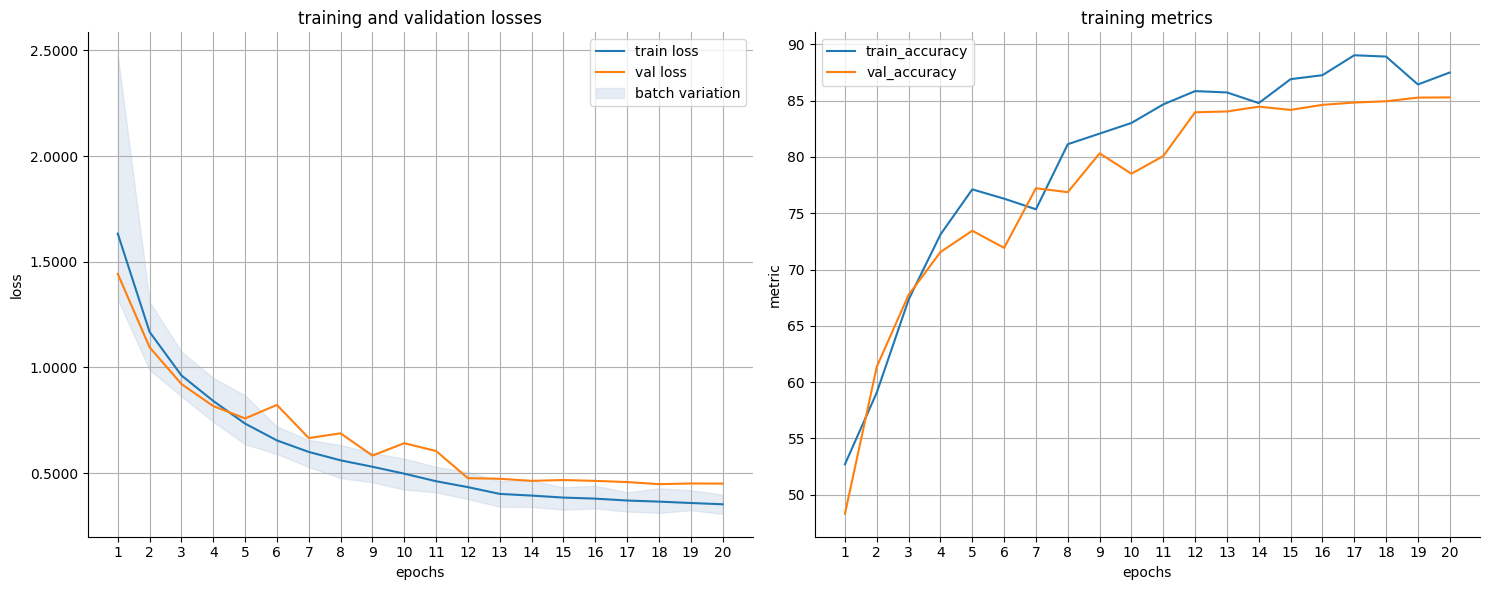

In [3]:
trainer3.set_learning_rate(0.01)
_ = trainer3.train(training_set=trainset, val_set=valset, num_epochs=10)

In [4]:
trainer3.set_learning_rate(0.001)
_ = trainer3.train(training_set=trainset, val_set=valset, num_epochs=10)

Learning rate updated to 0.001


[epoch 21] train loss: 0.3540 | val loss: 0.4458 | accuracy: 85.06%
Validation loss decreased (0.4478 --> 0.4458). Saving model.
[epoch 22] train loss: 0.3534 | val loss: 0.4446 | accuracy: 85.19%
Validation loss decreased (0.4458 --> 0.4446). Saving model.
[epoch 23] train loss: 0.3515 | val loss: 0.4458 | accuracy: 85.00%
EarlyStopping counter: 1 out of 2
[epoch 24] train loss: 0.3501 | val loss: 0.4436 | accuracy: 85.24%
Validation loss decreased (0.4446 --> 0.4436). Saving model.


In [8]:
trainer3.set_learning_rate(0.0001)
_ = trainer3.train(training_set=trainset, val_set=valset, num_epochs=10)


Learning rate updated to 0.0001
[epoch 27] train loss: 0.3834 | val loss: 0.4566 | accuracy: 84.54%
Validation loss decreased (0.4568 --> 0.4566). Saving model.
[epoch 28] train loss: 0.3826 | val loss: 0.4567 | accuracy: 84.69%
EarlyStopping counter: 1 out of 2
[epoch 29] train loss: 0.3825 | val loss: 0.4565 | accuracy: 84.54%
Validation loss decreased (0.4566 --> 0.4565). Saving model.
Training was manually interrupted.


In [2]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# prepare datasets with custom transforms
trainset, valset = prepare_datasets(
    dataset_name=dataset_name, 
    data_root=data_root,
    transform_train=transform_train,
    transform_test=transform_val,
    normalize=False
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
from models.eight_layer_conv_net.architecture import EightLayerConvNet
from torch.optim.lr_scheduler import MultiStepLR

def train_model(model, model_name, num_epochs=200):
    optimizer = SGD(
        model.parameters(),
        lr=0.1,
        momentum=0.9,
        weight_decay=1e-4
    )
    
    # 32k and 48k iterations with batch_size=128
    scheduler = MultiStepLR(
        optimizer,
        milestones=[82, 123],  # ~32k and ~48k iterations
        gamma=0.1
    )
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=128,
        verbose=True,
        save_metrics=False,
        early_stopping_patience=5,
        early_stopping_delta=1e-4,  # 1e-4
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="wandb",
        wandb_project="cifar10",
        wandb_entity="futuregoose",
        sweep=True,
    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs  # 164 to reach ~64k iterations
    )
    
    return trainer

model3 = EightLayerConvNet()
trainer3 = train_model(model3, "EightLayerConvNet", num_epochs=200)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: evilgoosecode (futuregoose). Use `wandb login --relogin` to force relogin


Create sweep with ID: d5g3ze1j
Sweep URL: https://wandb.ai/futuregoose/cifar10/sweeps/d5g3ze1j
sweep url: https://wandb.ai/futuregoose/cifar10/sweeps/d5g3ze1j

Starting sweep...
Running 50 trials...


wandb: Agent Starting Run: ex9fezgf with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.01952193627299651
wandb: 	optimizer: SGD
wandb: 	scheduler: StepLR
wandb: 	step_size: 15
wandb: 	weight_decay: 6.765222947251714e-05



run silver-sweep-1 - batch_size: 64, lr: 0.01952, optimizer: SGD, weight_decay: 0.00007
[epoch 01] train loss: 1.5280 | val loss: 2.5364 | accuracy: 29.70%
Validation loss decreased (inf --> 2.5364). Saving model.

Training interrupted. Cleaning up...


Traceback (most recent call last):
  File "/home/gustaf/projects/deeplearning/deep_learning_tools/src/sweeps/sweep.py", line 249, in train_function
    train_loss = sweep_train_epoch(trainer, epoch)
  File "/home/gustaf/projects/deeplearning/deep_learning_tools/src/sweeps/sweep.py", line 133, in sweep_train_epoch
    wandb.log({
  File "/home/gustaf/projects/deeplearning/venv/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 440, in wrapper
    return func(self, *args, **kwargs)
  File "/home/gustaf/projects/deeplearning/venv/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 402, in wrapper_fn
    raise UsageError(resolved_message)
wandb.errors.errors.UsageError: Run (ex9fezgf) is finished. The call to `log` will be ignored. Please make sure that you are using an active run.
Traceback (most recent call last):
  File "/home/gustaf/projects/deeplearning/deep_learning_tools/src/sweeps/sweep.py", line 25, in wandb_run
    yield run
  File "/home/gustaf/projects/deeplearni

Error during training: Run (ex9fezgf) is finished. The call to `log` will be ignored. Please make sure that you are using an active run.
Error during sweep run: 'ZMQDisplayPublisher' object has no attribute '_orig_publish'


batch,▁▁▁▁▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇█████▁▁▁▂▂▂▃
batch_loss,██▆▆▆▄▅▃▄▅▅▄▄▃▃▃▃▃▃▄▂▃▃▄▂▃▃▄▃▁▄▅▂▁▂▂▁▁▂▂
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
batch,209
batch_loss,1.10732
epoch,2
train_accuracy,31.25


wandb: Ctrl + C detected. Stopping sweep.


Model state already saved as checkpoint.pt.

Sweep completed successfully!
View results at: https://wandb.ai/futuregoose/cifar10/sweeps/d5g3ze1j


## Step 5: Evaluate Models

In [ ]:
def evaluate_model(trainer, model_name):
    print(f"Evaluating {model_name}...")
    trainer.load_best_model()
    # assuming val_loader is the test set
    val_loss, metrics = trainer.evaluate(trainer.metrics_history['epochs'][-1], phase='val')
    print(f"{model_name} - Loss: {val_loss:.4f}, Metrics: {metrics}")

### Evaluate All Models

In [ ]:
evaluate_model(trainer1, "SimpleCNN")
evaluate_model(trainer2, "CNNWithBatchNorm")
evaluate_model(trainer3, "CNNWithDropout")

## Step 6: Plot Loss Curves

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(trainers, model_names):
    plt.figure(figsize=(10, 6))
    for trainer, name in zip(trainers, model_names):
        epochs = trainer.metrics_history['epochs']
        plt.plot(epochs, trainer.metrics_history['train_loss'], label=f"{name} Train Loss")
        plt.plot(epochs, trainer.metrics_history['val_loss'], label=f"{name} Val Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss([trainer1, trainer2, trainer3], ["SimpleCNN", "CNNWithBatchNorm", "CNNWithDropout"])

## Step 7: Analyze Per-Class Performance

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

def per_class_analysis(trainer, model_name):
    trainer.load_best_model()
    trainer.model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, targets in trainer.val_loader:
            data, targets = data.to(trainer.device), targets.to(trainer.device)
            outputs = trainer.model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())
    
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    
    cm = confusion_matrix(all_targets, all_preds)
    classes = trainset.classes
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(all_targets, all_preds, target_names=classes))



### Analyze All Models

## Conclusion